# Домашнее задание к занятию "Рекуррентные сети"

Задание 1.
Обучите нейронную сеть решать шифр Цезаря.

Что необходимо сделать:

* Написать алгоритм шифра Цезаря для генерации выборки (сдвиг на К каждой буквы. Например, при сдвиге на 2 буква “А” переходит в букву “В” и тп)
* Сделать нейронную сеть
* Обучить ее (вход - зашифрованная фраза, выход - дешифрованная фраза)
* Проверить качество

Задание 2.
Выполнить практическую работу из лекционного ноутбука.

* Построить RNN-ячейку на основе полносвязных слоев
* Применить построенную ячейку для генерации текста с выражениями героев сериала “Симпсоны”


### импорт библиотек

In [ ]:
import pandas as pd
import time
import torch
import re
import numpy as np
import matplotlib.pyplot as plt


## Задание 1

### Загрузка текста и препроцессинг

In [ ]:
df = pd.read_csv('/content/text.txt', sep = '/n', header=None, names = ['original'])
df

<ipython-input-3-c1d116b37645>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('/content/text.txt', sep = '/n', header=None, names = ['original'])


,original
0,Мцыри
1,1
2,"Немного лет тому назад,"
3,"Там, где, сливаяся, шумят,"
4,"Обнявшись, будто две сестры,"
...,...
774,И что вполголоса поет
775,Он мне про милую страну.
776,"И с этой мыслью я засну,"
777,И никого не прокляну!..»


In [ ]:
# функция для препроцессинга текста (оставляем только буквы русского алфавита без других символов)
ru_words = re.compile("[А-Яа-я]+")

def words_only(text):
    return " ".join(ru_words.findall(text)).lower()

In [ ]:
df['norm'] = df.original.apply(words_only)
df.replace({'' : np.NaN}, inplace = True) # замена строк с пустыми значениями на NaN
df.dropna(inplace = True) # удаление строк с Nan
df

,original,norm
0,Мцыри,мцыри
2,"Немного лет тому назад,",немного лет тому назад
3,"Там, где, сливаяся, шумят,",там где сливаяся шумят
4,"Обнявшись, будто две сестры,",обнявшись будто две сестры
5,"Струи Арагвы и Куры,",струи арагвы и куры
...,...,...
774,И что вполголоса поет,и что вполголоса поет
775,Он мне про милую страну.,он мне про милую страну
776,"И с этой мыслью я засну,",и с этой мыслью я засну
777,И никого не прокляну!..»,и никого не прокляну


### Шифрование текста

In [ ]:
# функция зашифровки
def encryption(text):
    alphabet = 'абвгдеёжзийклмнопрстуфхцчшщъыьэюяабвгдеёжзийклмнопрстуфхцчшщъыьэюя'
    text = text.lower()
    shift = 2
    result = ''
    for i in text:
        if i != ' ':
            location = alphabet.find(i) + shift # найти номер места в алфавите и прибавить сдвиг
        if i in alphabet:
            result += alphabet[location]  # записать в результат новую букву
        else:
            result += i
    return result

In [ ]:
# функция расшифровки

def decryption(text):
    alphabet = 'абвгдеёжзийклмнопрстуфхцчшщъыьэюяабвгдеёжзийклмнопрстуфхцчшщъыьэюя'
    text = text.lower()
    shift = 2
    result = ''
    for i in text:
        if i != ' ':
            location = alphabet.find(i) - shift
        if i in alphabet:
            result += alphabet[location]
        else:
            result += i
    return result

In [ ]:
df['encryption'] = df.norm.astype('str').apply(encryption) # зашифрованный текст
df['decryption'] = df.encryption.astype('str').apply(decryption) # расшифрованный текст для проверки

In [ ]:
df.head(10)

,original,norm,encryption,decryption
0,Мцыри,мцыри,ошэтк,мцыри
2,"Немного лет тому назад,",немного лет тому назад,пжопрер нжф фрох пвйвё,немного лет тому назад
3,"Там, где, сливаяся, шумят,",там где сливаяся шумят,фво еёж ункдвбуб ъхобф,там где сливаяся шумят
4,"Обнявшись, будто две сестры,",обнявшись будто две сестры,ргпбдъкую гхёфр ёдж ужуфтэ,обнявшись будто две сестры
5,"Струи Арагвы и Куры,",струи арагвы и куры,уфтхк втведэ к мхтэ,струи арагвы и куры
6,Был монастырь. Из-за горы,был монастырь из за горы,гэн орпвуфэтю кй йв ертэ,был монастырь из за горы
7,И нынче видит пешеход,и нынче видит пешеход,к пэпщж дкёкф сжъжчрё,и нынче видит пешеход
8,"Столбы обрушенных ворот,",столбы обрушенных ворот,уфрнгэ ргтхъжппэч дртрф,столбы обрушенных ворот
9,"И башни, и церковный свод;",и башни и церковный свод,к гвъпк к шжтмрдпэл удрё,и башни и церковный свод
10,Но не курится уж под ним,но не курится уж под ним,пр пж мхткфуб хи срё пко,но не курится уж под ним


### Нейронная сеть для дешифровки текста

#### Подготовка данных

In [ ]:
# создание словаря
CHARS = set('абвгдеёжзийклмнопрстуфхцчшщъыьэюя ')  # все символы, которые мы хотим использовать для кодировки = наш словарь
INDEX_TO_CHAR = ['none'] + [w for w in CHARS]  # все неизвестные символы будут получать тег none
CHAR_TO_INDEX = {w: i for i, w in enumerate(INDEX_TO_CHAR)}  # словарь токен-индекс

In [ ]:
# берем столбец входных данных с зашифрованными текстами (то, что будем подавать на вход в сеть)
input = df['encryption'].tolist()
input[:10]

['ошэтк',
 'пжопрер нжф фрох пвйвё',
 'фво еёж ункдвбуб ъхобф',
 'ргпбдъкую гхёфр ёдж ужуфтэ',
 'уфтхк втведэ к мхтэ',
 'гэн орпвуфэтю кй йв ертэ',
 'к пэпщж дкёкф сжъжчрё',
 'уфрнгэ ргтхъжппэч дртрф',
 'к гвъпк к шжтмрдпэл удрё',
 'пр пж мхткфуб хи срё пко']

In [ ]:
# берем столбец выходных данных с расшифрованными текстами (то, что будет таргетом)

output = df['decryption'].tolist()  # колонка с готовыми текстами
output[:10]

['мцыри',
 'немного лет тому назад',
 'там где сливаяся шумят',
 'обнявшись будто две сестры',
 'струи арагвы и куры',
 'был монастырь из за горы',
 'и нынче видит пешеход',
 'столбы обрушенных ворот',
 'и башни и церковный свод',
 'но не курится уж под ним']

In [ ]:
# токенезация
text_input = [[c for c in ph] for ph in input if type(ph) is str]
text_output = [[c for c in ph] for ph in output if type(ph) is str]

In [ ]:
# кодируем данные в вектора
MAX_LEN = 40  # мы хотим ограничить максимальную длину ввода
X = torch.zeros((len(text_input), MAX_LEN), dtype=int)  # создаём пустой вектор для текста, чтобы класть в него индексы токенов
for i in range(len(text_input)):  # для каждого предложения
    for j, w in enumerate(text_input[i]):  # для каждого токена
        if j >= MAX_LEN:
            break
        X[i, j] = CHAR_TO_INDEX.get(w, CHAR_TO_INDEX['none'])

Y = torch.zeros((len(text_output), MAX_LEN), dtype=int)  # создаём пустой вектор для текста, чтобы класть в него индексы токенов
for i in range(len(text_output)):  # для каждого предложения
    for j, w in enumerate(text_output[i]):  # для каждого токена
        if j >= MAX_LEN:
            break
        Y[i, j] = CHAR_TO_INDEX.get(w, CHAR_TO_INDEX['none'])

In [ ]:
X[0]

tensor([21,  6, 34, 33, 17,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0])

In [ ]:
Y[0]

tensor([20, 31, 28, 16,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0])

In [ ]:
Y.shape

torch.Size([750, 40])

### Эмбендинг и RNN ячейка

In [ ]:
embeddings = torch.nn.Embedding(len(INDEX_TO_CHAR), 35)  # размер словаря * размер вектора для кодировки каждого слова
t = embeddings(X[0:5])
t.shape

torch.Size([5, 40, 35])

In [ ]:
rnn = torch.nn.RNN(35, 128, batch_first=True)  # на вход - размер эмбеддинга, размер скрытого состояния и порядок размерностей
o, s = rnn(t)
# вектора для слов: батч * число токенов * размер скрытого состояния
# вектор скрытого состояния: число вектров (один) * батч * размер скрытого состояния
o.shape, s.shape

(torch.Size([5, 40, 128]), torch.Size([1, 5, 128]))

#### RNN

In [ ]:
class Network(torch.nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.embedding = torch.nn.Embedding(35, 50)
        self.rnn = torch.nn.RNN(50, 128)
        self.out = torch.nn.Linear(128, 35)

    def forward(self, sentences, state=None):
        x = self.embedding(sentences)
        x, s = self.rnn(x) # берём выход с последнего слоя для всех токенов, а не скрытое состояние
        return self.out(x)

model = Network()
model

Network(
  (embedding): Embedding(35, 50)
  (rnn): RNN(50, 128)
  (out): Linear(in_features=128, out_features=35, bias=True)
)

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=.05)

#### Обучение

In [ ]:
history_loss = []

for ep in range(100):
    start = time.time()
    train_loss = 0.
    train_passed = 0

    for i in range(int(len(X) / 100)):
        # берём батч в 100 элементов
        X_batch = X[i * 100:(i + 1) * 100]
        Y_batch = Y[i * 100:(i + 1) * 100].flatten()


        optimizer.zero_grad()

        answers = model.forward(X_batch)
        answers = answers.view(-1, len(INDEX_TO_CHAR))
        loss = criterion(answers, Y_batch)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()
        train_passed += 1

    print("Epoch {}. Time: {:.3f}, Train loss: {:.3f}".format(ep, time.time() - start, train_loss / train_passed))
    history_loss.append(train_loss / train_passed)

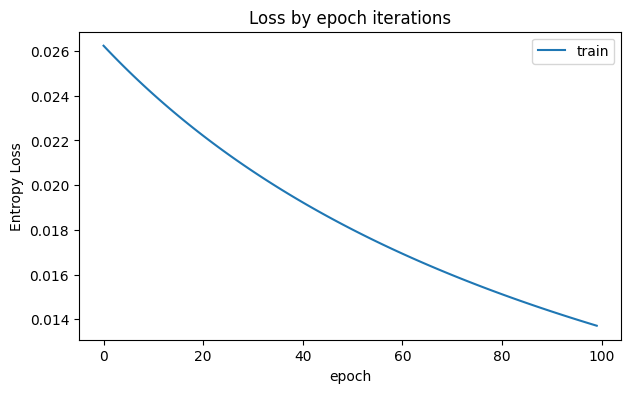

In [ ]:
# график для отображения динамики loss
plt.figure(figsize=(7, 4))

plt.plot(history_loss, label = 'train')

plt.title('Loss by epoch iterations')
plt.ylabel('Entropy Loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [ ]:
def generate_decryption_sentence(word):
    sentence = list(word.lower())
    sentence = [CHAR_TO_INDEX.get(s, 0) for s in sentence]
    answers = model.forward(torch.tensor(sentence))
    probas, indices = answers.topk(1)
    return ''.join([INDEX_TO_CHAR[ind.item()] for ind in indices.flatten()])

In [ ]:
encryption('Мой дядя самых честных правил')

'орл ёбёб увоэч щжуфпэч ствдкн'

In [ ]:
generate_decryption_sentence('Орл ёБёб увоэч щжуфпэч ствдкн')

'мой дядя самых честных правил'

Вывод: Обучение прошло успешно, ошибка заметно падает. Тест проходит очень хорошо, незнакомые фразы расшифровываются правильно.

## Задание 2


1. Построить RNN-ячейку на основе полносвязных слоев
2. Применить построенную ячейку для генерации текста с выражениями героев сериала “Симпсоны”


### Загрузка и подготовка данных

In [ ]:
df = pd.read_csv('/content/data.csv')
df.head()

,Unnamed: 0,id,episode_id,number,raw_text,timestamp_in_ms,speaking_line,character_id,location_id,raw_character_text,raw_location_text,spoken_words,normalized_text,word_count
0,0,10368,35,29,"Lisa Simpson: Maggie, look. What's that?",235000,True,9,5.0,Lisa Simpson,Simpson Home,"Maggie, look. What's that?",maggie look whats that,4.0
1,1,10369,35,30,Lisa Simpson: Lee-mur. Lee-mur.,237000,True,9,5.0,Lisa Simpson,Simpson Home,Lee-mur. Lee-mur.,lee-mur lee-mur,2.0
2,2,10370,35,31,Lisa Simpson: Zee-boo. Zee-boo.,239000,True,9,5.0,Lisa Simpson,Simpson Home,Zee-boo. Zee-boo.,zee-boo zee-boo,2.0
3,3,10372,35,33,Lisa Simpson: I'm trying to teach Maggie that ...,245000,True,9,5.0,Lisa Simpson,Simpson Home,I'm trying to teach Maggie that nature doesn't...,im trying to teach maggie that nature doesnt e...,24.0
4,4,10374,35,35,"Lisa Simpson: It's like an ox, only it has a h...",254000,True,9,5.0,Lisa Simpson,Simpson Home,"It's like an ox, only it has a hump and a dewl...",its like an ox only it has a hump and a dewlap...,18.0


In [ ]:
df.dropna(inplace=True)

In [ ]:
phrases = df['normalized_text'].tolist()  # колонка с предобработанными текстами
phrases[:10]

['maggie look whats that',
 'lee-mur lee-mur',
 'zee-boo zee-boo',
 'im trying to teach maggie that nature doesnt end with the barnyard i want her to have all the advantages that i didnt have',
 'its like an ox only it has a hump and a dewlap hump and dew-lap hump and dew-lap',
 'you know his blood type how romantic',
 'oh yeah whats my shoe size',
 'ring',
 'yes dad',
 'ooh look maggie what is that do-dec-ah-edron dodecahedron']

In [ ]:
# токенизация
text = [[c for c in ph] for ph in phrases if type(ph) is str]

In [ ]:
# Создание словаря и кодировка текста

CHARS = set('abcdefghijklmnopqrstuvwxyz ')  # все символы, которые мы хотим использовать для кодировки = наш словарь
INDEX_TO_CHAR = ['none'] + [w for w in CHARS]  # все неизвестные символы будут получать тег none
CHAR_TO_INDEX = {w: i for i, w in enumerate(INDEX_TO_CHAR)}  # словарь токен-индекс

In [ ]:
# векторы с фразами
MAX_LEN = 50  # мы хотим ограничить максимальную длину ввода
X = torch.zeros((len(text), MAX_LEN), dtype=int)  # создаём пустой вектор для текста, чтобы класть в него индексы токенов
for i in range(len(text)):  # для каждого предложения
    for j, w in enumerate(text[i]):  # для каждого токена
        if j >= MAX_LEN:
            break
        X[i, j] = CHAR_TO_INDEX.get(w, CHAR_TO_INDEX['none'])

In [ ]:
X[0].shape

torch.Size([50])

In [ ]:
# превращение векторов в эмбединги
embeddings = torch.nn.Embedding(len(INDEX_TO_CHAR), 28)  # размер словаря * размер вектора для кодировки каждого слова
t = embeddings(X[0:5])
t.shape

torch.Size([5, 50, 28])

In [ ]:
rnn = torch.nn.RNN(28, 128, batch_first=True)  # на вход - размер эмбеддинга, размер скрытого состояния и порядок размерностей
o, s = rnn(t)
# вектора для слов: батч * число токенов * размер скрытого состояния
# вектор скрытого состояния: число вектров (один) * батч * размер скрытого состояния
o.shape, s.shape

(torch.Size([5, 50, 128]), torch.Size([1, 5, 128]))

In [ ]:
rnn

RNN(28, 128, batch_first=True)

### Построение нейронной сети

In [ ]:
class Network(torch.nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.embedding = torch.nn.Embedding(28, 30)
        self.rnn = torch.nn.RNN(30, 128)
        self.out = torch.nn.Linear(128, 28)

    def forward(self, sentences, state=None):
        x = self.embedding(sentences)
        x, s = self.rnn(x) # берём выход с последнего слоя для всех токенов, а не скрытое состояние
        return self.out(x)

In [ ]:
model = Network()

In [ ]:
criterion = torch.nn.CrossEntropyLoss()  # типичный лосс многоклассовой классификации
optimizer = torch.optim.Adam(model.parameters(), lr=.01)

### Обучение

In [ ]:
history_loss = []


for ep in range(100):
    start = time.time()
    train_loss = 0.
    train_passed = 0

    for i in range(int(len(X) / 100)):
        # берём батч в 100 элементов
        batch = X[i * 100:(i + 1) * 100]
        X_batch = batch[:, :-1]
        Y_batch = batch[:, 1:].flatten()

        optimizer.zero_grad()
        answers = model.forward(X_batch)
        answers = answers.view(-1, len(INDEX_TO_CHAR))
        loss = criterion(answers, Y_batch)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()
        train_passed += 1

    if ep % 10 == 0:
            print("Epoch {}. Time: {:.3f}, Train loss: {:.3f}".format(ep, time.time() - start, train_loss / train_passed))
    history_loss.append(train_loss / train_passed)


Epoch 0. Time: 2.419, Train loss: 1.726
Epoch 10. Time: 2.390, Train loss: 1.624
Epoch 20. Time: 3.050, Train loss: 1.617
Epoch 30. Time: 2.349, Train loss: 1.614
Epoch 40. Time: 2.361, Train loss: 1.630
Epoch 50. Time: 2.460, Train loss: 1.636
Epoch 60. Time: 2.808, Train loss: 1.630
Epoch 70. Time: 2.659, Train loss: 1.631
Epoch 80. Time: 2.413, Train loss: 1.630
Epoch 90. Time: 2.424, Train loss: 1.629


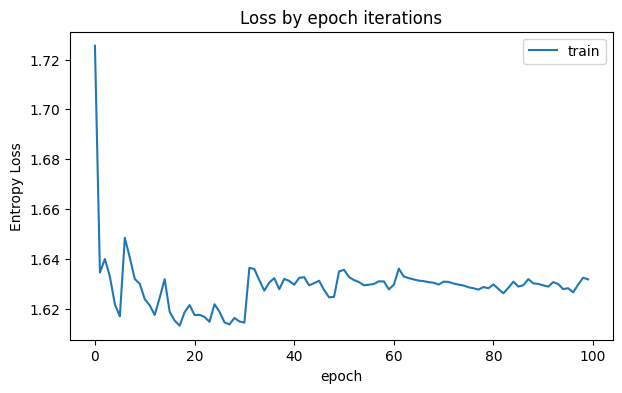

In [ ]:
# график для отображения динамики loss
plt.figure(figsize=(7, 4))

plt.plot(history_loss, label = 'train')

plt.title('Loss by epoch iterations')
plt.ylabel('Entropy Loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [ ]:
def generate_sentence(word):
    sentence = list(word)
    sentence = [CHAR_TO_INDEX.get(s, 0) for s in sentence]
    answers = model.forward(torch.tensor(sentence))
    probas, indices = answers.topk(1)
    return ''.join([INDEX_TO_CHAR[ind.item()] for ind in indices.flatten()])

In [ ]:
generate_sentence('like an ox only')

' ne tn t ct  eo'

Вывод: текст генерируется, но качество получаемых выходов плохое